In [1]:
# Load the data
import pandas as pd
train_df = pd.read_csv("../../cleaned_dataset/split_data/model_selection/train.csv")
test_df = pd.read_csv("../../cleaned_dataset/split_data/model_selection/test.csv")

In [2]:
# Get all of the unique labels for train / test sets 
train_labels = list(train_df['room'].unique())
test_labels = list(test_df['room'].unique())

# Labels that appear in BOTH train and test
common_labels = list(set(train_labels) & set(test_labels))

# Now filter the train_df and test_df so that
# remove all record in train_df whose labels not in test labels 
# and remove all record in test_df whose labels not in train labels 
# therefore we can have a proper train and test df such that the labels appear 
# in train and test should be the same and vice versa
train_df = train_df[train_df['room'].isin(common_labels)].reset_index(drop=True)
test_df  = test_df[test_df['room'].isin(common_labels)].reset_index(drop=True)

In [3]:
# CELL 1: Create room groups for sequences
import pandas as pd
import numpy as np

def create_room_groups(df):
    """
    Create room_group column to identify consecutive room visits.
    Each time room changes, we start a new group.
    """
    df = df.sort_values('timestamp').reset_index(drop=True)
    df['room_group'] = (df['room'] != df['room'].shift()).cumsum()
    return df

# Apply to both train and test
train_df = create_room_groups(train_df)
test_df = create_room_groups(test_df)

In [6]:
# CELL 2: Create 23-dimensional beacon count vectors
def create_beacon_count_vectors(df):
    """
    For each window, create a 23-dim vector where each value is the 
    percentage of times that beacon appeared (ignore beacons 24, 25)
    """
    vectors = []
    
    for _, group in df.groupby('timestamp'):
        # Count how many times each beacon appears in this window
        beacon_counts = group['mac address'].value_counts()
        total_readings = len(group)
        
        # Create 23-dim vector (beacons 1-23)
        vector = [0.0] * 23
        for beacon_id, count in beacon_counts.items():
            if 1 <= beacon_id <= 23:  # Only beacons 1-23
                vector[beacon_id - 1] = count / total_readings
        
        vectors.append({
            'timestamp': group['timestamp'].iloc[0],
            'room': group['room'].iloc[0],
            'room_group': group['room_group'].iloc[0],
            'beacon_vector': vector
        })
    
    return pd.DataFrame(vectors)

# Create vectors for train and test
print("Creating beacon vectors for train set...")
train_vectors = create_beacon_count_vectors(train_df)
print(f"✓ Train vectors created: {len(train_vectors)} windows")

print("\nCreating beacon vectors for test set...")
test_vectors = create_beacon_count_vectors(test_df)
print(f"✓ Test vectors created: {len(test_vectors)} windows")

# Show example
print("\nExample beacon vector:")
print(f"Timestamp: {train_vectors.iloc[0]['timestamp']}")
print(f"Room: {train_vectors.iloc[0]['room']}")
print(f"Vector: {train_vectors.iloc[0]['beacon_vector'][:5]}... (showing first 5 beacons)")

Creating beacon vectors for train set...
✓ Train vectors created: 15052 windows

Creating beacon vectors for test set...
✓ Test vectors created: 5889 windows

Example beacon vector:
Timestamp: 2023-04-10 14:21:46+09:00
Room: kitchen
Vector: [0.0, 0.0, 0.0, 0.6936936936936937, 0.0]... (showing first 5 beacons)


In [7]:
# CELL 3: Create sequences grouped by room_group
def create_sequences_from_groups(vector_df, min_length=3, max_length=50):
    """
    Group consecutive windows into sequences based on room_group.
    Filter out sequences that are too short or too long.
    """
    sequences = []
    labels = []
    
    for (room, room_group), group in vector_df.groupby(['room', 'room_group']):
        group = group.sort_values('timestamp')
        seq_length = len(group)
        
        # Filter by length
        if seq_length < min_length:
            continue  # Too short, skip
        
        if seq_length > max_length:
            # Too long, truncate to last max_length windows
            group = group.tail(max_length)
            seq_length = max_length
        
        # Extract beacon vectors as sequence
        sequence = [row['beacon_vector'] for _, row in group.iterrows()]
        
        sequences.append(sequence)
        labels.append(room)
    
    return sequences, labels

# Create sequences
print("Creating sequences from room groups...")
X_train_seq, y_train = create_sequences_from_groups(train_vectors, min_length=3, max_length=50)
X_test_seq, y_test = create_sequences_from_groups(test_vectors, min_length=3, max_length=50)

print(f"\n✓ Train sequences: {len(X_train_seq)}")
print(f"✓ Test sequences: {len(X_test_seq)}")

# Show sequence length statistics
train_lengths = [len(seq) for seq in X_train_seq]
test_lengths = [len(seq) for seq in X_test_seq]

print(f"\nTrain sequence lengths:")
print(f"  Min: {min(train_lengths)}, Max: {max(train_lengths)}, Mean: {np.mean(train_lengths):.1f}")

print(f"\nTest sequence lengths:")
print(f"  Min: {min(test_lengths)}, Max: {max(test_lengths)}, Mean: {np.mean(test_lengths):.1f}")

# Show label distribution
print(f"\nTrain label distribution:")
print(pd.Series(y_train).value_counts().sort_index())
print(f"\nTest label distribution:")
print(pd.Series(y_test).value_counts().sort_index())

Creating sequences from room groups...

✓ Train sequences: 166
✓ Test sequences: 83

Train sequence lengths:
  Min: 3, Max: 50, Mean: 28.1

Test sequence lengths:
  Min: 3, Max: 50, Mean: 30.9

Train label distribution:
501               1
502               1
506               1
511               3
512               1
513               1
517               1
518               1
520               3
522               4
523               8
cafeteria        44
cleaning         10
hallway          21
kitchen          28
nurse station    38
Name: count, dtype: int64

Test label distribution:
501               1
502               3
506               2
511               1
512               2
513               1
518               1
520               2
522               1
523               6
cafeteria        21
cleaning          8
hallway           3
kitchen          10
nurse station    21
Name: count, dtype: int64


In [9]:
# CELL 4: Pad sequences to same length for LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

print(f"Number of classes: {len(label_encoder.classes_)}")
print(f"Classes: {label_encoder.classes_}")

# Pad sequences (pad with zeros at the beginning)
# Convert list of sequences to numpy array
X_train_padded = pad_sequences(X_train_seq, padding='pre', dtype='float32', value=0.0)
X_test_padded = pad_sequences(X_test_seq, padding='pre', dtype='float32', value=0.0)

print(f"\n✓ Padded train shape: {X_train_padded.shape}")
print(f"  (num_sequences, max_sequence_length, num_features)")
print(f"✓ Padded test shape: {X_test_padded.shape}")

c:\Users\ADMIN\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


Number of classes: 16
Classes: ['501' '502' '506' '511' '512' '513' '517' '518' '520' '522' '523'
 'cafeteria' 'cleaning' 'hallway' 'kitchen' 'nurse station']

✓ Padded train shape: (166, 50, 23)
  (num_sequences, max_sequence_length, num_features)
✓ Padded test shape: (83, 50, 23)


In [10]:
# CELL 5: Build and compile LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking
from tensorflow.keras.utils import to_categorical

# Convert labels to one-hot encoding
num_classes = len(label_encoder.classes_)
y_train_onehot = to_categorical(y_train_encoded, num_classes=num_classes)
y_test_onehot = to_categorical(y_test_encoded, num_classes=num_classes)

# Build LSTM model
model = Sequential([
    # Masking layer to ignore padded zeros
    Masking(mask_value=0.0, input_shape=(X_train_padded.shape[1], X_train_padded.shape[2])),
    
    # LSTM layers
    LSTM(128, return_sequences=True),
    Dropout(0.3),
    
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    
    # Dense layers
    Dense(32, activation='relu'),
    Dropout(0.2),
    
    # Output layer
    Dense(num_classes, activation='softmax')
])

# Compile model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model architecture:")
model.summary()

Model architecture:


c:\Users\ADMIN\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking (Masking)               │ (None, 50, 23)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 50, 128)        │        77,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 129,840 (507.19 KB)

 Trainable params: 129,840 (507.19 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# CELL 6: Train the model (OPTIMIZED FOR MACRO F1) - FIXED
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

class MacroF1Callback(Callback):
    """
    Custom callback to monitor macro F1 score on validation set
    and implement early stopping based on macro F1
    """
    def __init__(self, validation_data, patience=10):
        super().__init__()
        self.X_val, self.y_val = validation_data
        self.patience = patience
        self.best_macro_f1 = 0
        self.wait = 0
        self.best_weights = None
        
    def on_epoch_end(self, epoch, logs=None):
        # Predict on validation set
        y_pred_probs = self.model.predict(self.X_val, verbose=0)
        y_pred_encoded = np.argmax(y_pred_probs, axis=1)
        y_true_encoded = np.argmax(self.y_val, axis=1)
        
        # Calculate macro F1
        macro_f1 = f1_score(y_true_encoded, y_pred_encoded, average='macro', zero_division=0)
        
        print(f"\nEpoch {epoch + 1}: val_macro_f1 = {macro_f1:.4f}")
        
        # Check if this is the best macro F1
        if macro_f1 > self.best_macro_f1:
            self.best_macro_f1 = macro_f1
            self.wait = 0
            self.best_weights = self.model.get_weights()
            print(f"  → New best macro F1! Saving weights.")
        else:
            self.wait += 1
            print(f"  → No improvement (patience: {self.wait}/{self.patience})")
            
            if self.wait >= self.patience:
                print(f"\n⚠️ Early stopping triggered! Restoring best weights (macro F1 = {self.best_macro_f1:.4f})")
                self.model.stop_training = True
                self.model.set_weights(self.best_weights)

# Check class distribution and filter out classes with only 1 sample
from collections import Counter

print("Analyzing class distribution in training set...")
class_counts = Counter(y_train_encoded)
print(f"\nClass counts:")
for class_idx, count in sorted(class_counts.items()):
    class_name = label_encoder.classes_[class_idx]
    print(f"  {class_name}: {count} sequences")

# Find classes with at least 2 samples (needed for train/val split)
valid_classes = [class_idx for class_idx, count in class_counts.items() if count >= 2]
print(f"\nClasses with >= 2 samples: {len(valid_classes)}/{len(class_counts)}")

# Filter data to only include valid classes
valid_mask = np.isin(y_train_encoded, valid_classes)
X_train_filtered = X_train_padded[valid_mask]
y_train_filtered = y_train_onehot[valid_mask]
y_train_encoded_filtered = y_train_encoded[valid_mask]

print(f"\nFiltered training data:")
print(f"  Original: {len(X_train_padded)} sequences")
print(f"  Filtered: {len(X_train_filtered)} sequences")
print(f"  Removed: {len(X_train_padded) - len(X_train_filtered)} sequences")

# Split train data for validation (20%) - NO stratification
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_filtered, y_train_filtered, 
    test_size=0.2, 
    random_state=42
    # No stratify - some classes still too small
)

print(f"\nTrain split: {len(X_train_split)} sequences")
print(f"Val split: {len(X_val_split)} sequences")

# Callbacks
macro_f1_callback = MacroF1Callback(
    validation_data=(X_val_split, y_val_split),
    patience=10
)

reduce_lr = ReduceLROnPlateau(
    monitor='loss',  # Monitor training loss
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# Compute class weights on the filtered data
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train_encoded_filtered),
    y=y_train_encoded_filtered
)
class_weight_dict = {class_idx: class_weights[i] for i, class_idx in enumerate(np.unique(y_train_encoded_filtered))}

print("\nClass weights (to handle imbalance):")
for class_idx, weight in sorted(class_weight_dict.items()):
    class_name = label_encoder.classes_[class_idx]
    print(f"  {class_name}: {weight:.2f}")

# Train
print("\n" + "=" * 80)
print("Training LSTM model (optimizing for MACRO F1)...")
print("=" * 80)

history = model.fit(
    X_train_split, y_train_split,
    validation_data=(X_val_split, y_val_split),
    epochs=50,
    batch_size=32,
    class_weight=class_weight_dict,  # Balance classes
    callbacks=[macro_f1_callback, reduce_lr],
    verbose=1
)

print(f"\n✓ Training complete!")
print(f"✓ Best validation macro F1: {macro_f1_callback.best_macro_f1:.4f}")

Analyzing class distribution in training set...

Class counts:
  501: 1 sequences
  502: 1 sequences
  506: 1 sequences
  511: 3 sequences
  512: 1 sequences
  513: 1 sequences
  517: 1 sequences
  518: 1 sequences
  520: 3 sequences
  522: 4 sequences
  523: 8 sequences
  cafeteria: 44 sequences
  cleaning: 10 sequences
  hallway: 21 sequences
  kitchen: 28 sequences
  nurse station: 38 sequences

Classes with >= 2 samples: 9/16

Filtered training data:
  Original: 166 sequences
  Filtered: 159 sequences
  Removed: 7 sequences

Train split: 127 sequences
Val split: 32 sequences

Class weights (to handle imbalance):
  511: 5.89
  520: 5.89
  522: 4.42
  523: 2.21
  cafeteria: 0.40
  cleaning: 1.77
  hallway: 0.84
  kitchen: 0.63
  nurse station: 0.46

Training LSTM model (optimizing for MACRO F1)...
Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.0999 - loss: 3.0741
Epoch 1: val_macro_f1 = 0.1652
  → New best macro F1! Saving weights.
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 296ms/st

In [13]:
# CELL 7: Evaluate on test set
from sklearn.metrics import f1_score, classification_report

# Make predictions
y_pred_probs = model.predict(X_test_padded)
y_pred_encoded = np.argmax(y_pred_probs, axis=1)
y_pred = label_encoder.inverse_transform(y_pred_encoded)

# Calculate macro F1
macro_f1 = f1_score(y_test, y_pred, average='macro')

print("=" * 80)
print("LSTM MODEL EVALUATION RESULTS")
print("=" * 80)
print(f"\n🎯 MACRO F1 SCORE: {macro_f1:.4f}")
print(f"   XGBoost baseline was: 0.30")
print(f"   XGBoost + temporal features was: 0.29")

if macro_f1 > 0.30:
    improvement = (macro_f1 - 0.30) / 0.30 * 100
    print(f"   ✓ Improvement over baseline: +{improvement:.1f}%")
else:
    decline = (0.30 - macro_f1) / 0.30 * 100
    print(f"   ✗ Decline: -{decline:.1f}%")

print("\n" + "=" * 80)
print("PER-CLASS F1 SCORES")
print("=" * 80)

# Get per-class F1 scores
report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)

class_f1_scores = []
for class_name in sorted(set(y_test)):
    if class_name in report:
        f1 = report[class_name]['f1-score']
        support = report[class_name]['support']
        class_f1_scores.append((class_name, f1, support))

class_f1_scores.sort(key=lambda x: -x[1])

print(f"\n{'Room':<20s} {'F1 Score':<12s} {'Support':<10s}")
print("-" * 80)
for room, f1, support in class_f1_scores:
    print(f"{room:<20s} {f1:<12.4f} {int(support):<10d}")

print("\n" + "=" * 80)
print("SUMMARY STATISTICS")
print("=" * 80)
print(f"Average F1 (macro): {macro_f1:.4f}")
print(f"Best performing room: {class_f1_scores[0][0]} (F1={class_f1_scores[0][1]:.4f})")
print(f"Worst performing room: {class_f1_scores[-1][0]} (F1={class_f1_scores[-1][1]:.4f})")
print(f"Rooms with F1 > 0.5: {sum(1 for _, f1, _ in class_f1_scores if f1 > 0.5)}/{len(class_f1_scores)}")
print(f"Rooms with F1 < 0.2: {sum(1 for _, f1, _ in class_f1_scores if f1 < 0.2)}/{len(class_f1_scores)}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
LSTM MODEL EVALUATION RESULTS

🎯 MACRO F1 SCORE: 0.3705
   XGBoost baseline was: 0.30
   XGBoost + temporal features was: 0.29
   ✓ Improvement over baseline: +23.5%

PER-CLASS F1 SCORES

Room                 F1 Score     Support   
--------------------------------------------------------------------------------
511                  1.0000       1         
523                  0.9231       6         
nurse station        0.6818       21        
520                  0.6667       2         
522                  0.6667       1         
cleaning             0.6667       8         
kitchen              0.6452       10        
cafeteria            0.3077       21        
501                  0.0000       1         
502                  0.0000       3         
506                  0.0000       2         
512                  0.0000       2         
513                  0.0000       1         
518                  0.0000       1         
hallway          

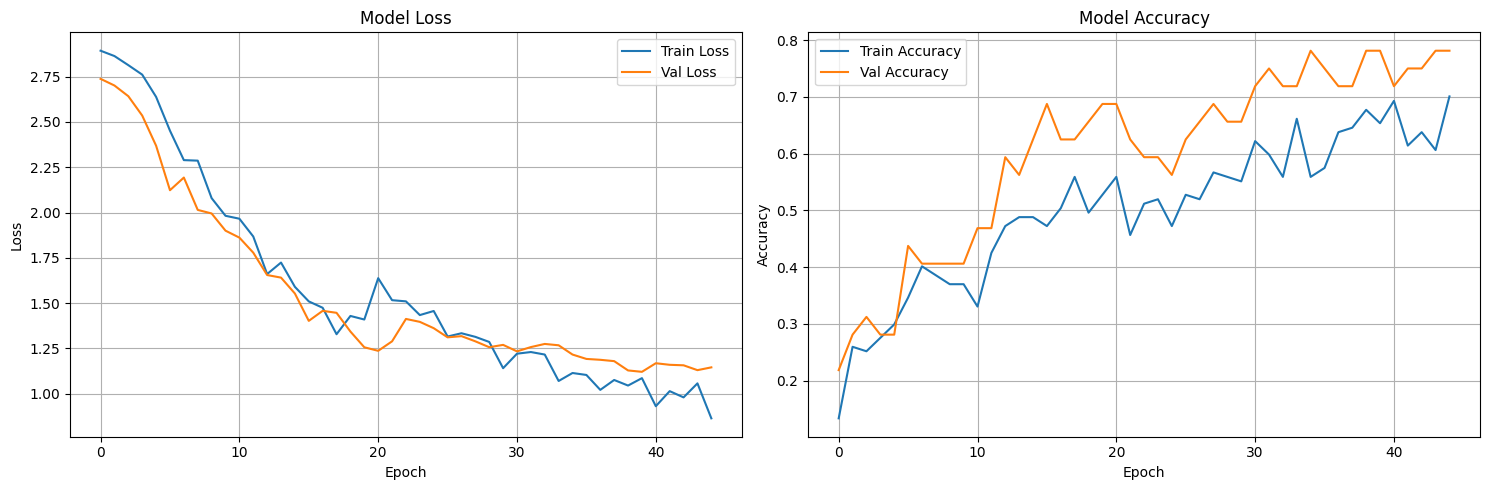


Final train accuracy: 0.7008
Final validation accuracy: 0.7812


In [14]:
# CELL 8: Plot training history
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
axes[0].plot(history.history['loss'], label='Train Loss')
axes[0].plot(history.history['val_loss'], label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Model Loss')
axes[0].legend()
axes[0].grid(True)

# Accuracy plot
axes[1].plot(history.history['accuracy'], label='Train Accuracy')
axes[1].plot(history.history['val_accuracy'], label='Val Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Model Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig('lstm_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nFinal train accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final validation accuracy: {history.history['val_accuracy'][-1]:.4f}")